# Data Processing

In [1]:
from utils import load_musicxml

def play_music(music_data):
    """
    Plays the loaded sheet music data as MIDI.

    Input: music data
    Output: music
    """
    music_data.show('midi')


file_name = './data/01 G-Sangnyeongsan_Haegeum_part(0807).musicxml.xml'
print('file_name:', file_name, '\n')
music_data = load_musicxml(file_name)
play_music(music_data)


file_name: ./data/01 G-Sangnyeongsan_Haegeum_part(0807).musicxml.xml 



In [2]:
# Tokenization
from data_processing import music_to_tokens

tokens = music_to_tokens(file_name)
print("number of tokens:", len(tokens[0]))
print("Pitch:", tokens[0][:20])
print("Octave:", tokens[1][:20])
print("Duration:", tokens[2][:20])

number of tokens: 274
Pitch: ['<SOS>', 'rest', 'rest', 'rest', 'rest', 'E-', 'A-', 'A-', 'E-', 'B-', 'B-', 'A-', 'E-', 'F', 'A-', 'A-', 'E-', 'B-', 'B-', 'A-']
Octave: ['<SOS>', 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Duration: ['<SOS>', '4/12', '72/12', '48/12', '48/12', '2/12', '10/12', '8/12', '4/12', '12/12', '8/12', '4/12', '8/12', '4/12', '24/12', '56/12', '4/12', '24/12', '4/12', '68/12']


## Loading Preprocessed Data

In [3]:
group_number = 2

import pickle
# Load data from file
with open(f'./data/group{group_number}_song_information.pkl', 'rb') as f:
    Song_informations = pickle.load(f)

In [4]:
Song_informations[0].keys()

dict_keys(['Song_name', 'Song_pitch', 'Song_octave', 'Song_duration'])

In [5]:
from data_processing import build_predefined_vocabs, build_vocab_mapping, music_to_tokens
from dataset import GukAkDataset

# Creating Predefined Vocabularies
pitch_vocab, octave_vocab, duration_vocab = build_predefined_vocabs()
pitch_token_to_idx, pitch_idx_to_token = build_vocab_mapping(pitch_vocab)
octave_token_to_idx, octave_idx_to_token = build_vocab_mapping(octave_vocab)
duration_token_to_idx, duration_idx_to_token = build_vocab_mapping(duration_vocab)

dataset = GukAkDataset(Song_informations=Song_informations,
                       pitch_token_to_idx=pitch_token_to_idx,
                       octave_token_to_idx=octave_token_to_idx,
                       duration_token_to_idx=duration_token_to_idx,
                       pad=False,
                       max_length=None)

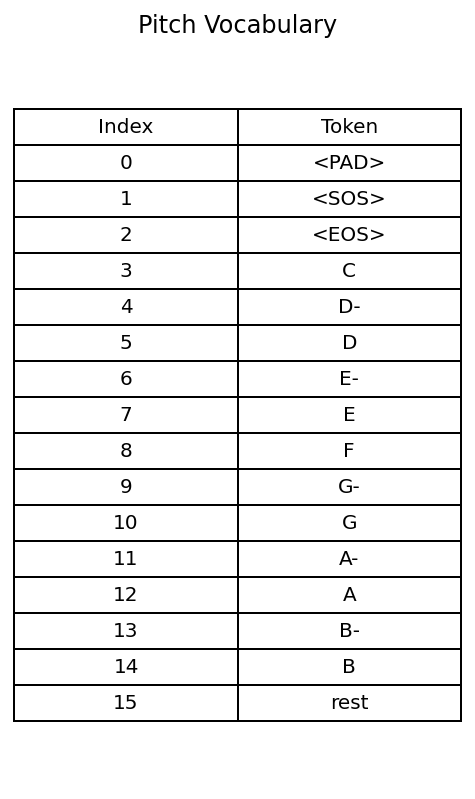

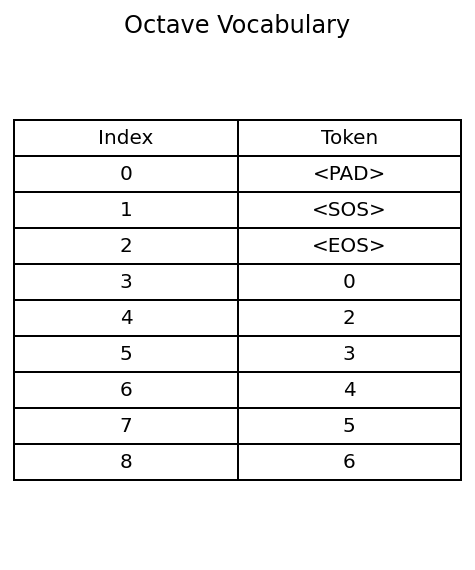

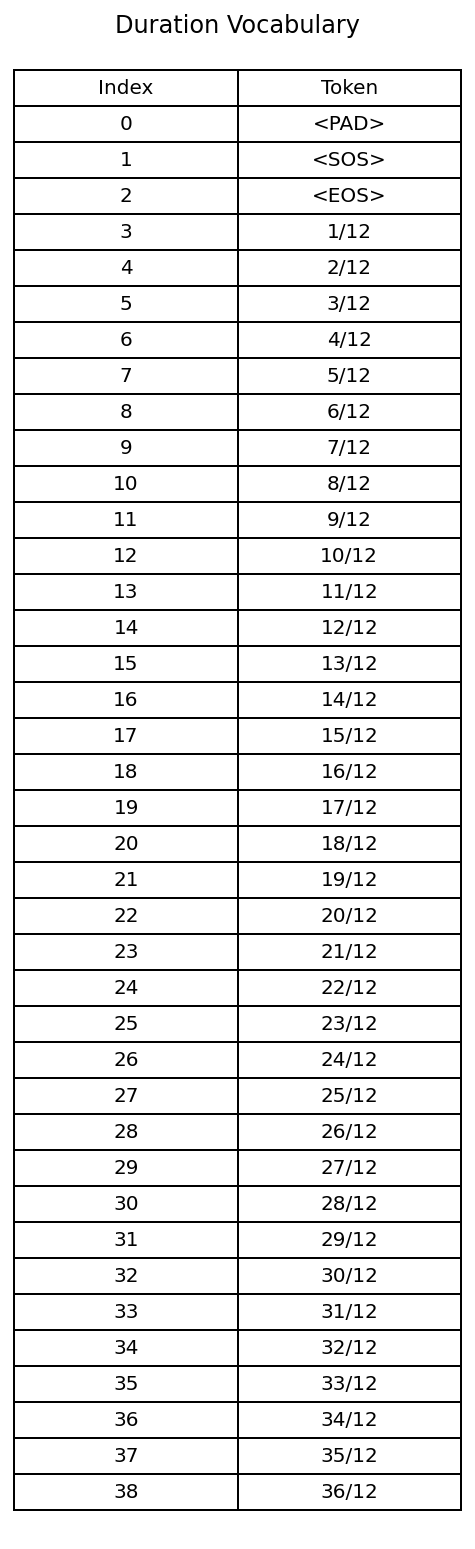

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_vocab(vocab, title="Vocabulary"):
    """
    Visualizes a list of tokens as a table in a plot.

    vocab: A list of tokens (e.g., pitch_vocab)
    title: The title of the plot
    """
    # Create a DataFrame: index and tokens as columns
    df = pd.DataFrame({
        "Index": list(range(len(vocab))),
        "Token": vocab
    })

    # Create a figure (adjust the vertical length according to the number of tokens)
    fig, ax = plt.subplots(figsize=(4, len(vocab) * 0.3 + 2))
    ax.axis('tight')
    ax.axis('off')

    # Display the DataFrame content as a table
    table = ax.table(cellText=df.values, colLabels=df.columns, loc="center", cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.title(title)
    plt.show()

# Example of predefined vocabularies (created previously with build_predefined_vocabs())
pitch_vocab, octave_vocab, duration_vocab = build_predefined_vocabs()

# Execute visualization
visualize_vocab(pitch_vocab, "Pitch Vocabulary")
visualize_vocab(octave_vocab, "Octave Vocabulary")
visualize_vocab(duration_vocab, "Duration Vocabulary")


In [7]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Model Configuration and Training Code

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from model import GukAkLSTM

# Hyperparameters
n_epochs = 200 # Try 2000
lr = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pitch_vocab_size = len(pitch_vocab)
octave_vocab_size = len(octave_vocab)
duration_vocab_size = len(duration_vocab)

model = GukAkLSTM(pitch_vocab_size, octave_vocab_size, duration_vocab_size).to(device)


optimizer = optim.Adam(model.parameters(), lr=lr)

# Set the <PAD> token index as ignore_index for each channel.
pitch_ignore_index = pitch_token_to_idx["<PAD>"]
octave_ignore_index = octave_token_to_idx["<PAD>"]
duration_ignore_index = duration_token_to_idx["<PAD>"]

criterion_pitch = nn.CrossEntropyLoss(ignore_index=pitch_ignore_index)
criterion_octave = nn.CrossEntropyLoss(ignore_index=octave_ignore_index)
criterion_duration = nn.CrossEntropyLoss(ignore_index=duration_ignore_index)

In [9]:
for epoch in range(n_epochs):
    model.train()
    total_loss = 0.0

    for batch in data_loader:
        pitch_batch, octave_batch, duration_batch = batch

        # Move tensors to the device (each tensor shape: [batch_size, max_length])
        pitch_batch = pitch_batch.to(device)
        octave_batch = octave_batch.to(device)
        duration_batch = duration_batch.to(device)

        # Configure input and target sequences:
        # Input: Sequence from the start to the (T-1)th token [<SOS>, first_note, ..., last_note]
        # Target: Sequence from the 1st to the Tth token (i.e., the answer one step ahead) [first_note, ..., last_note, <EOS>]
        input_pitch = pitch_batch[:, :-1]      # (batch_size, max_length-1)
        target_pitch = pitch_batch[:, 1:]      # (batch_size, max_length-1)

        input_octave = octave_batch[:, :-1]
        target_octave = octave_batch[:, 1:]

        input_duration = duration_batch[:, :-1]
        target_duration = duration_batch[:, 1:]

        optimizer.zero_grad()

        # Pass inputs to the model to obtain logits for each channel.
        # Shape of each output:
        #   output_pitch: (batch_size, seq_len, pitch_vocab_size)
        #   output_octave: (batch_size, seq_len, octave_vocab_size)
        #   output_duration: (batch_size, seq_len, duration_vocab_size)
        output_pitch, output_octave, output_duration, _ = model(input_pitch, input_octave, input_duration)

        loss_pitch = criterion_pitch(output_pitch.view(-1, pitch_vocab_size), target_pitch.view(-1))
        loss_octave = criterion_octave(output_octave.view(-1, octave_vocab_size), target_octave.view(-1))
        loss_duration = criterion_duration(output_duration.view(-1, duration_vocab_size), target_duration.view(-1))

        loss = loss_pitch + loss_octave + loss_duration
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/200, Loss: 6.4807
Epoch 2/200, Loss: 4.9598
Epoch 3/200, Loss: 4.8386
Epoch 4/200, Loss: 4.8361
Epoch 5/200, Loss: 4.8265
Epoch 6/200, Loss: 4.8192
Epoch 7/200, Loss: 4.8129
Epoch 8/200, Loss: 4.7533
Epoch 9/200, Loss: 4.7292
Epoch 10/200, Loss: 4.6962
Epoch 11/200, Loss: 4.6150
Epoch 12/200, Loss: 4.5585
Epoch 13/200, Loss: 4.4906
Epoch 14/200, Loss: 4.4410
Epoch 15/200, Loss: 4.3565
Epoch 16/200, Loss: 4.3020
Epoch 17/200, Loss: 4.2547
Epoch 18/200, Loss: 4.1808
Epoch 19/200, Loss: 4.1307
Epoch 20/200, Loss: 4.0712
Epoch 21/200, Loss: 3.9950
Epoch 22/200, Loss: 3.9442
Epoch 23/200, Loss: 3.8690
Epoch 24/200, Loss: 3.8062
Epoch 25/200, Loss: 3.7620
Epoch 26/200, Loss: 3.7139
Epoch 27/200, Loss: 3.6835
Epoch 28/200, Loss: 3.6310
Epoch 29/200, Loss: 3.5843
Epoch 30/200, Loss: 3.5616
Epoch 31/200, Loss: 3.5347
Epoch 32/200, Loss: 3.5133
Epoch 33/200, Loss: 3.4732
Epoch 34/200, Loss: 3.4165
Epoch 35/200, Loss: 3.3793
Epoch 36/200, Loss: 3.3603
Epoch 37/200, Loss: 3.3183
Epoch 38/2

In [10]:
from generate_music import generate_musics, remove_special_tokens
import numpy as np

# Example Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generated_music = generate_musics(model,
                                pitch_token_to_idx, octave_token_to_idx, duration_token_to_idx,
                                pitch_idx_to_token, octave_idx_to_token, duration_idx_to_token,
                                device, max_gen_length=300)

gen_pitch, gen_octave, gen_duration = generated_music
print("Generated Pitch Sequence:", gen_pitch)
print("Generated Octave Sequence:", gen_octave)
print("Generated Duration Sequence:", gen_duration)
                                
gen_pitch, gen_octave, gen_duration = remove_special_tokens(generated_music)

print("Generated Pitch Sequence:", gen_pitch)
print("Generated Octave Sequence:", gen_octave)
print("Generated Duration Sequence:", gen_duration)

Generated Pitch Sequence: ['rest', 'F', 'A-', 'rest', 'A-', 'D-', 'rest', 'B-', 'E-', 'A-', 'E-', 'B-', 'G-', 'B-', 'E-', 'B-', 'G-', 'B-', 'E-', 'G-', 'B-', 'A-', 'E-', 'A-', 'B-', 'G-', 'B-', 'G-', 'E-', 'D-', 'B-', 'A-', 'B-', 'E-', 'B-', 'B-', 'D-', 'B-', 'A-', 'B-', 'B-', 'E-', 'B-', 'E-', 'E-', 'A-', 'D-', 'B-', 'E-', 'D-', 'B-', 'A-', 'B-', 'E-', 'D-', 'B-', 'E-', 'B-', 'E-', 'D-', 'G-', 'B-', 'D-', 'B-', 'E-', 'D-', 'B-', 'B-', 'E-', 'B-', 'G-', 'E-', 'B-', 'E-', 'B-', 'E-', 'E-', 'D-', 'B-', 'A-', 'B-', 'A-', 'E-', 'B-', 'E-', 'D-', 'B-', 'E-', 'B-', 'B-', 'E-', 'B-', 'B-', 'E-', 'B-', 'A-', 'G-', 'E-', 'A-', 'B-', 'D-', 'E-', 'A-', 'B-', 'E-', 'G-', 'B-', 'D-', 'G-', 'E-', 'A-', 'E-', 'B-', 'E-', 'E-', 'F', 'B-', 'E-', 'B-', 'B-', 'E-', 'B-', 'D-', 'E-', 'G-', 'E-', 'A-', 'B-', 'D-', 'B-', 'A-', 'B-', 'D-', 'E-', 'A-', 'E-', 'D-', 'E-', 'G-', 'B-', 'E-', 'B-', 'D-', 'A-', 'E-', 'B-', 'B-', 'B-', 'D-', 'B-', 'A-', 'B-', 'A-', 'B-', 'G-', 'E-', 'G-', 'E-', 'G-', 'B-', 'B-', 'E-

In [11]:
def save_stream_as_midi(music_stream, file_path):
    """
    Saves a music21 stream object as a MIDI file.

    Arguments:
      - music_stream: a music21 stream object
      - file_path: path to the MIDI file to be saved (e.g., "generated_music.mid")
    """
    music_stream.write('midi', fp=file_path)

def save_stream_as_musicxml(music_stream, file_path):
    """
    Saves a music21 stream object as a MusicXML file.

    Arguments:
      - music_stream: a music21 stream object
      - file_path: path to the MusicXML file to be saved (e.g., "generated_music.musicxml")
    """
    music_stream.write('musicxml', fp=file_path)

In [12]:
from data_processing import tokens_to_music21

cutting_number = 4 
time_signature = f'{3*cutting_number}/8'
info_tokens = [gen_pitch, gen_octave, gen_duration]

new_music = tokens_to_music21(info_tokens, time_signature= time_signature, cutting_number = cutting_number)

save_stream_as_midi(new_music, 'GukAkLSTM.midi')
save_stream_as_musicxml(new_music, 'GukAkLSTM.musicxml')

In [13]:
# # Print score
# print('installing lilypond...')
# !apt-get install lilypond > /dev/null

# import time
# from IPython.display import Image

# def show(music):
#   fpath = str(music.write('lily.png'))
#   time.sleep(10)
#   display(Image(fpath))

# from music21 import converter
# loaded_music = converter.parse('GukAkLSTM.musicxml')
# show(loaded_music)

In [14]:
new_music.show('midi')